# Chapter 2: Time series graphics

Load common libraries and settings:

In [2]:
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=".*FigureCanvasAgg is non-interactive.*"
)
import os
os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
np.set_printoptions(suppress=True)
np.random.seed(1)
import random
random.seed(1)
import pandas as pd
pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
from utilsforecast.plotting import plot_series as plot_series_utils
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

Load additional libraries:

In [3]:
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

## 2.1 `DataFrame` Objects

### The index variables

A time series is a list of numbers indexed by a time step. 

In [4]:
x = [123, 39, 78, 52, 110]
yr = list(range(2015, 2020))
df = pd.DataFrame({"Year": yr, "Observation": x})
df.set_index("Year", inplace=True)
df

,Observation
Year,
2015,123
2016,39
2017,78
2018,52
2019,110


In [5]:
df.columns

Index(['Observation'], dtype='str')

### The key variables

In [6]:
olympic_running = pd.read_csv("./data/olympic_running_unparsed.csv")
olympic_running.head(10)

,Year,Length,Sex,Time
0,1896,100,men,12.0
1,1900,100,men,11.0
2,1904,100,men,11.0
3,1908,100,men,10.8
4,1912,100,men,10.8
5,1916,100,men,NaN
6,1920,100,men,10.8
7,1924,100,men,10.6
8,1928,100,men,10.8
9,1932,100,men,10.3


In [7]:
olrun = olympic_running.copy()
olrun.shape

(312, 4)

In [8]:
olrun.columns

Index(['Year', 'Length', 'Sex', 'Time'], dtype='str')

In [9]:
olrun['Sex'].unique()

<StringArray>
['men', 'women']
Length: 2, dtype: str

In [10]:
olrun['Length'].unique()

array([  100,   200,   400,   800,  1500,  5000, 10000])

### Working with timeseries dataframes

In [11]:
pbs = pd.read_csv("./data/PBS_unparsed.csv")        # sales data on pharma products in Australia
pbs['Month'] = pd.to_datetime(pbs['Month'])
pbs.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991-07-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991-08-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991-09-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991-10-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991-11-01,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


In [12]:
pbs.shape

(67596, 9)

In [13]:
a10 = pbs.query('ATC2 == "A10"')    # select *rows* corresponding to diabetes drugs (ATC code A10)
a10 = a10.filter(['Month', 'Concession', 'Type', 'Cost'])   # Select only some *columns* for analysis
a10.head()

,Month,Concession,Type,Cost
1524,1991-07-01,Concessional,Co-payments,2.093e+06
1525,1991-08-01,Concessional,Co-payments,1.796e+06
1526,1991-09-01,Concessional,Co-payments,1.777e+06
1527,1991-10-01,Concessional,Co-payments,1.849e+06
1528,1991-11-01,Concessional,Co-payments,1.686e+06


The `df.filter()` method differs from the `df.loc()` method in that the former is primarily used for subsetting rows or columns based on matching criteria in their labels, e.g. partial string matching, regex, `items`, `like`, etc, whereas the latter selects data by explicit row/column labels or boolean conditions. `filter()` doesn't filter based on content, only on labels of the index; `loc()` can filter based on the content (values) with the df e.g. `df.loc(df['col']>5).

The `agg()` method allows us to aggregate data across keys, e.g. in computing the total cost per month regardless of `Concession` and `Type`.

In [14]:
total_cost_df = a10.groupby('Month', as_index=False).agg({'Cost': 'sum'})
total_cost_df.rename(columns={'Cost': 'TotalC'}, inplace=True)
total_cost_df.head()

,Month,TotalC
0,1991-07-01,3.527e+06
1,1991-08-01,3.181e+06
2,1991-09-01,3.252e+06
3,1991-10-01,3.611e+06
4,1991-11-01,3.566e+06


In [15]:
total_cost_df.shape

(204, 2)

We can see now that the dataset spans 204 months. We can also create new variables using `assign()`, e.g. changing units from dollars to millions of dollars:

In [16]:
total_cost_df = total_cost_df.assign(
    Cost = round(total_cost_df['TotalC'] / 1e6, 2)
)
total_cost_df.head()

,Month,TotalC,Cost
0,1991-07-01,3.527e+06,3.53
1,1991-08-01,3.181e+06,3.18
2,1991-09-01,3.252e+06,3.25
3,1991-10-01,3.611e+06,3.61
4,1991-11-01,3.566e+06,3.57


In [17]:
total_cost_df.to_csv('./data/total_cost_df.csv', index=False)

### Read a csv file

Quarterly data for the prison population in Australia, disaggregated by state, gender, legal status, and indigenous status (ATSI = Aboriginal or Torres Strait Islander):

In [18]:
prison = pd.read_csv('./data/prison_population.csv')
prison.head()

,Date,State,Gender,Legal,Indigenous,Count
0,2005-03-01,ACT,Female,Remanded,ATSI,0
1,2005-03-01,ACT,Female,Remanded,Non-ATSI,2
2,2005-03-01,ACT,Female,Sentenced,ATSI,0
3,2005-03-01,ACT,Female,Sentenced,Non-ATSI,5
4,2005-03-01,ACT,Male,Remanded,ATSI,7


The dates are stored as individual days, but the data is actually quarterly, so we need to convert `Date` to quarters.

In [19]:
prison['Date'] = pd.to_datetime(prison['Date'])         # Convert 'Date' from string to datetime
prison['Quarter'] = prison['Date'].dt.to_period('Q')    # Create col. 'Quarter' by converting 'Date' to quarters
prison = prison.drop(columns=['Date'])                  # Drop the original 'Date' column, not needed anymore
prison.set_index('Quarter', inplace=True)               # Set 'Quarter' as the index of the dataframe
prison.sort_values(by=['State', 'Gender', 'Legal', 'Indigenous'])    # Sort by the specified columns in ascending order
prison.head()

,State,Gender,Legal,Indigenous,Count
Quarter,,,,,
2005Q1,ACT,Female,Remanded,ATSI,0
2005Q1,ACT,Female,Remanded,Non-ATSI,2
2005Q1,ACT,Female,Sentenced,ATSI,0
2005Q1,ACT,Female,Sentenced,Non-ATSI,5
2005Q1,ACT,Male,Remanded,ATSI,7


### The seasonal period

## 2.2 Time plots

The obvious graph to start with is a plot of observations vs. time index. Consecutive observations are often joined by straight lines. The following plot will show the weekly economy passenger load on Ansett airlines between Melbourne and Sydney.

In [20]:
ansett = pd.read_csv('./data/ansett.csv')
ansett.head()

,ds,Airports,Class,y
0,1989-07-10,ADL-PER,Business,193
1,1989-07-17,ADL-PER,Business,254
2,1989-07-24,ADL-PER,Business,185
3,1989-07-31,ADL-PER,Business,254
4,1989-08-07,ADL-PER,Business,191


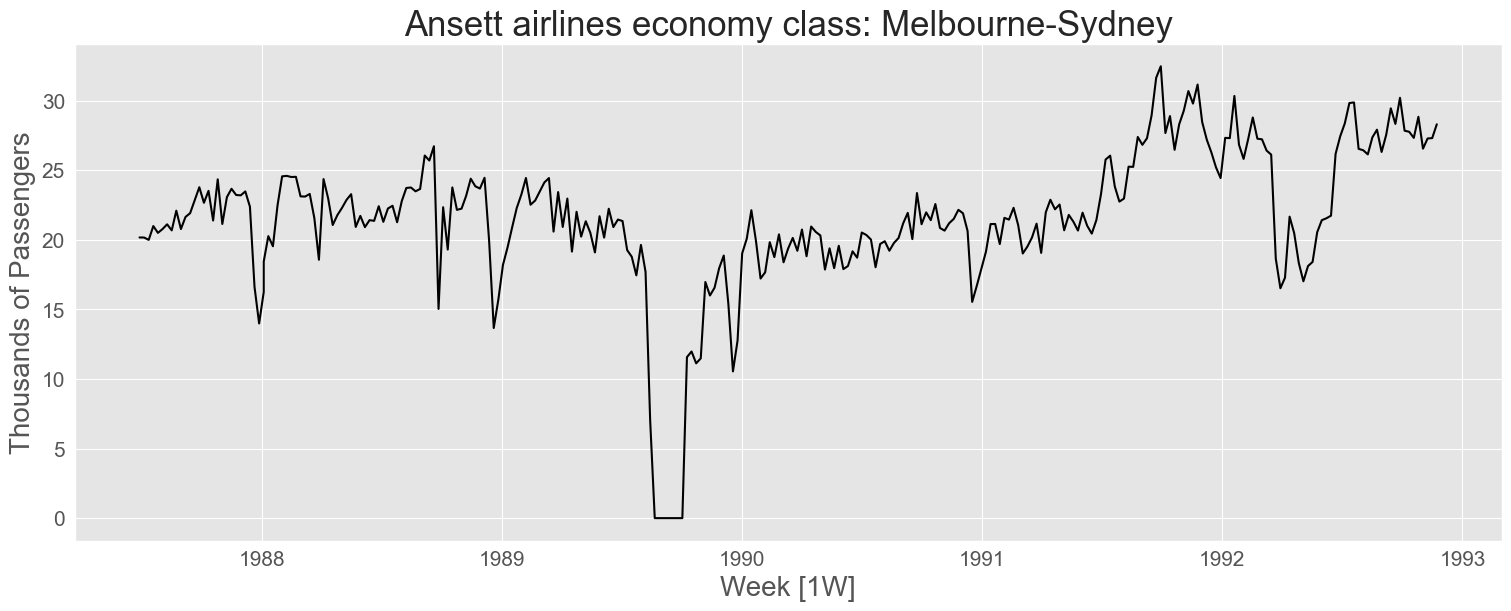

In [21]:
ansett['ds'] = pd.to_datetime(ansett['ds'])
melsyd_economy = ansett.query(
    'Airports == "MEL-SYD" & Class == "Economy"'
).copy()
melsyd_economy['y'] = melsyd_economy['y'] / 1000
plot_series(                                            # from utilsforecast library
    df = melsyd_economy,
    id_col = 'Airports',
    time_col = 'ds',
    target_col = 'y',
    ylabel = 'Thousands of Passengers',
    xlabel = 'Week [1W]',
    title = 'Ansett airlines economy class: Melbourne-Sydney'
)

Note:
- There was a period in 1989 where zero passengers were carried. This was due to an industrial dispute shutting down the airline.
- There was a period of reduced load in 1992, bucking the trend. This was due to a trial in which some economy class seats were replaced by business class seats.
- A large increase in passenger load occurred in the second half of 1991.
- There are some large dips in load around the start of each year, due to holiday effects.
- There is a long-term fluctuation in which the series trends upward in 1987, downward in 1989, and increases again through 1990 and 1991. 

Any model needs to take these features into account to make an effective forecast. 

Now we can plot the `total_cost_df` that we made earlier:

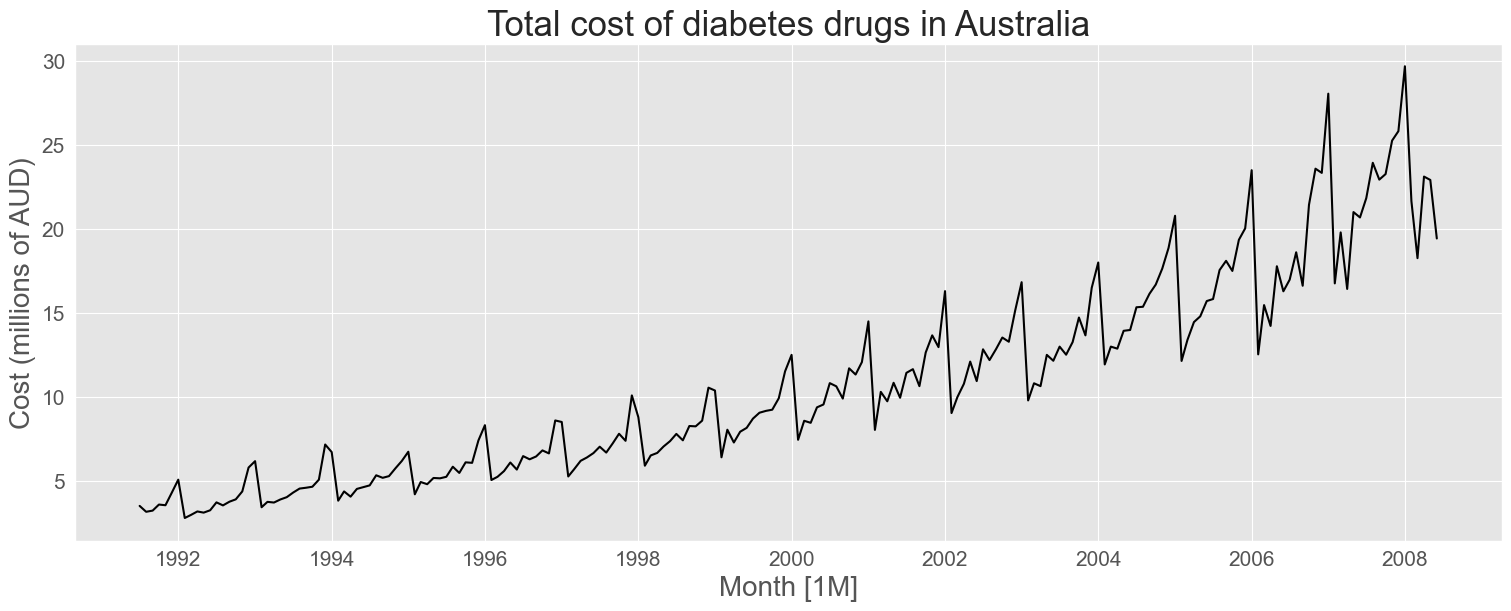

In [22]:
total_cost_df['unique_id'] = 'total_cost'       # Create a unique id column for the plot_series method
plot_series(
    df = total_cost_df,
    id_col = 'unique_id',
    time_col = 'Month',
    target_col = 'Cost',
    ylabel = 'Cost (millions of AUD)',
    xlabel = 'Month [1M]',
    title = 'Total cost of diabetes drugs in Australia'
)

Note the clear and increasing trend, as well as the strong seasonal pattern that increases in amplitude over time. The sudden drop at the start of the year is due to a government subsidization scheme that makes it cost-effective for patients to stockpile drugs at the end of the calendar year. Any forecasts need to capture the trend and the seasonal pattern. 

## 2.3 Time series patterns

- **Trend**
    - A trend exists when there's a long term increase/decrease in the data, but it doesn't have to be linear. 
- **Seasonal**
    - A seasonal pattern occurs when a time series is affected by time of they year, day of the week, hour of the day, etc. Seasonality is always of fixed and known period, though more than one seasonal pattern can exist simultaneously. 
- **Cyclic**
    - A cycle occurs when the data rises and falls absent a fixed frequency, usually due to economic conditions related to the "business cycle". The duration of these is typically around 2 years. 

## 2.4 Seasonal Plots

Similar to a time plot except the data are plotted against the individual "seasons" in which the data were observed. For example, using the antidiabetic drug sales:

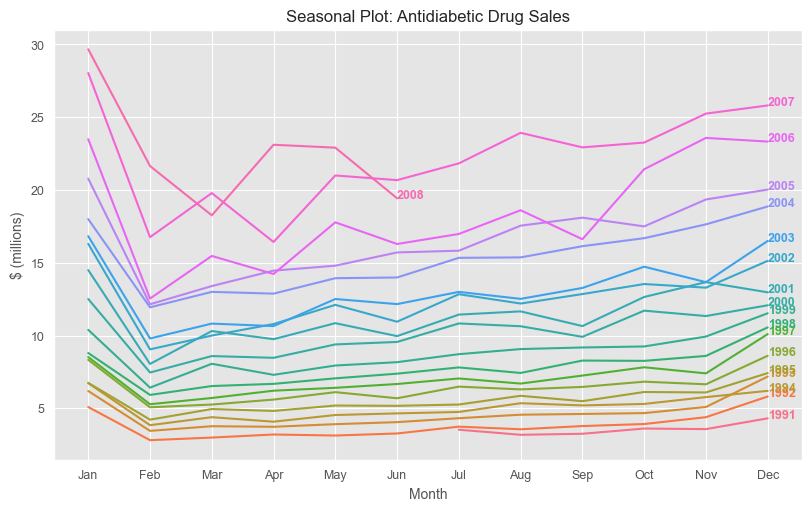

In [23]:
total_cost_df['Month_name'] = total_cost_df['Month'].dt.strftime('%b')  # Extract month name from 'Month' column
total_cost_df['Year'] = total_cost_df['Month'].dt.year                  # Extract year from 'Month' column
total_cost_df['Month_num'] = total_cost_df['Month'].dt.month            # Extract month number from 'Month' column
unique_years = total_cost_df['Year'].unique()

year_palette = sns.color_palette("husl", n_colors=len(unique_years))
fig, ax = plt.subplots()
sns.lineplot(data=total_cost_df,
  x="Month_num", y="Cost",
  hue="Year", palette=year_palette, legend=False, ax=ax,
)
ax.set_title("Seasonal Plot: Antidiabetic Drug Sales")
ax.set_xlabel("Month")
ax.set_ylabel("$ (millions)")
ax.set_xticks(
  ticks=range(1, 13),
  labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
)

min_year = unique_years.min()
for year, subset in total_cost_df.groupby("Year"):
  ax.text(
    subset["Month_num"].iloc[-1],
    subset["Cost"].iloc[-1],
    str(year),
    fontsize=9,
    weight="bold",
    color=year_palette[year - min_year],
  )
fig.show()

### Multiple seasonal periods

When the data has seasonality at different levels of granularity, we can group the data according to the different seasonalities and plot them (for instance the daily pattern, weekly pattern, yearly pattern, etc).

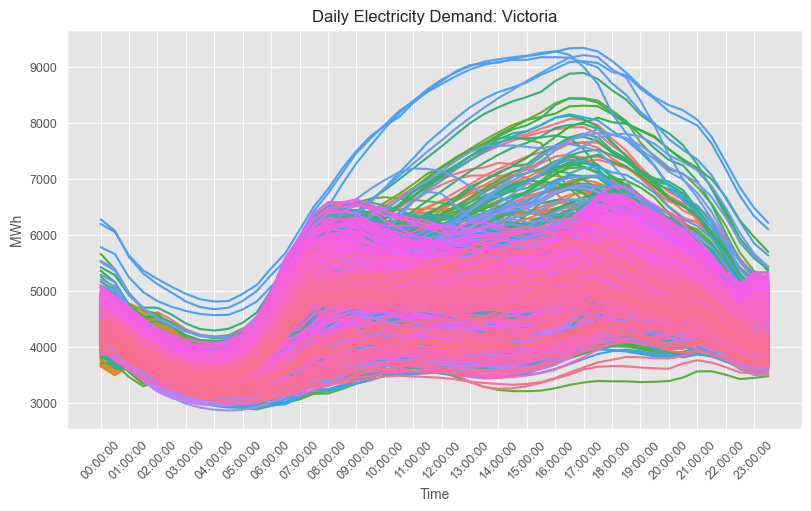

In [24]:
vic_elec_df = pd.read_csv("./data/vic_elec.csv")               # electricity demand data for Victoria, Australia
vic_elec_df["ds"] = pd.to_datetime(vic_elec_df["ds"])          # convert 'ds' col to datetime
vic_elec_demand = vic_elec_df[vic_elec_df["unique_id"] == "Demand"].copy() # extract rows corresponding to electricity demand only
vic_elec_demand["hour-minute"] = \
  vic_elec_demand["ds"].dt.strftime("%H:%M:%S")             # extract hour and minute from 'ds' column for plotting
vic_elec_demand["day"] = vic_elec_demand["ds"].dt.date      # extract day from 'ds' column for plotting

fig, ax = plt.subplots()
sns.lineplot(data=vic_elec_demand, 
    x="hour-minute", y="y",
    hue="day", palette="husl",
    legend=False, ax=ax,
)
unique_ticks = vic_elec_demand["hour-minute"].unique()
ticks_to_plot = unique_ticks[::2]
ax.set_xticks(ticks=range(0, len(unique_ticks), 2), labels=ticks_to_plot,
    rotation=45)
ax.set_title("Daily Electricity Demand: Victoria")
ax.set_xlabel("Time")
ax.set_ylabel("MWh")
fig.show()

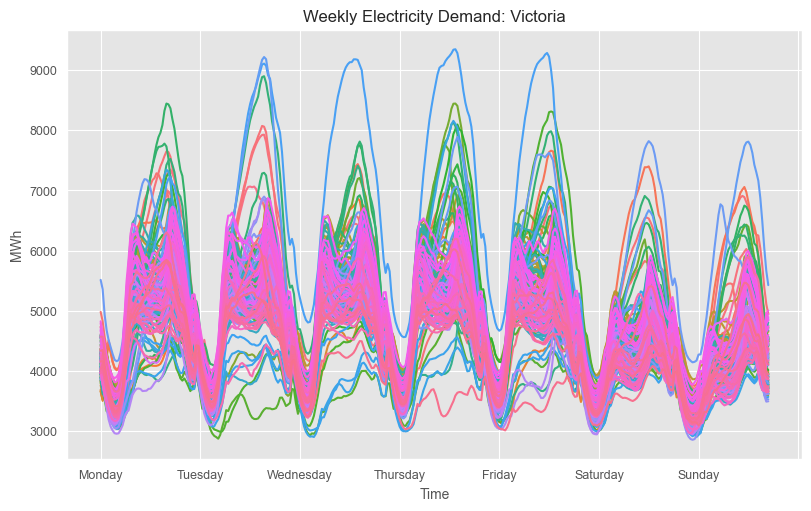

In [25]:
vic_elec_demand["day_of_week"] = vic_elec_demand["ds"].dt.day_name()
vic_elec_demand = vic_elec_demand[
    (vic_elec_demand["ds"] >= "2012-01-02") &
    (vic_elec_demand["ds"] < "2014-12-29")
].copy()

weeks = vic_elec_demand["ds"].dt.to_period("W-SUN").dt.start_time
unique_weeks = weeks.unique()
palette = sns.color_palette("husl", n_colors=len(unique_weeks))
color_map = dict(zip(unique_weeks, palette))

groups = vic_elec_demand["ds"].dt.to_period("W-SUN").dt.start_time
fig, ax = plt.subplots()
for df_week in vic_elec_demand.groupby(groups):
    week, df_w = df_week
    df_w.plot(
        y="y",
        x="day_of_week",
        ax=ax,
        color=color_map[week],
        label=str(week.date())
    )
ax.get_legend().remove()
ax.set_title("Weekly Electricity Demand: Victoria")
ax.set_ylabel("MWh")
ax.set_xlabel("Time")
fig.show()

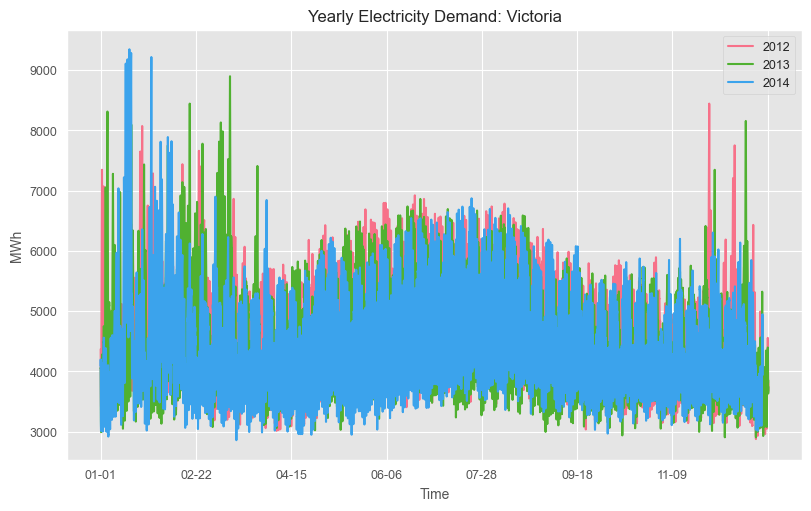

In [26]:
vic_elec_demand["day_of_year"] = vic_elec_demand["ds"].dt.strftime("%m-%d")

unique_years = vic_elec_demand["ds"].dt.year.unique()
palette = sns.color_palette("husl", n_colors=len(unique_years))
color_map = dict(zip(unique_years, palette))

fig, ax = plt.subplots()
for df_year in vic_elec_demand.groupby(vic_elec_demand["ds"].dt.year):
    year, df_y = df_year
    df_y.plot(
        y="y",
        x="day_of_year",
        ax=ax,
        label=str(year),
        color=color_map[year]
    )
ax.set_title("Yearly Electricity Demand: Victoria")
ax.set_ylabel("MWh")
ax.set_xlabel("Time")
fig.show()

## Seasonal subseries plots

Another way to emphasize seasonal patterns is to collect the data for each different seaason together in separate mini time plots.

In [27]:
total_cost_df.head()

,Month,TotalC,Cost,unique_id,Month_name,Year,Month_num
0,1991-07-01,3.527e+06,3.53,total_cost,Jul,1991,7
1,1991-08-01,3.181e+06,3.18,total_cost,Aug,1991,8
2,1991-09-01,3.252e+06,3.25,total_cost,Sep,1991,9
3,1991-10-01,3.611e+06,3.61,total_cost,Oct,1991,10
4,1991-11-01,3.566e+06,3.57,total_cost,Nov,1991,11


/var/folders/sz/kx_yftld6rs9z42kwpsm47y40000gn/T/ipykernel_55012/3284505244.py:31: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.2)


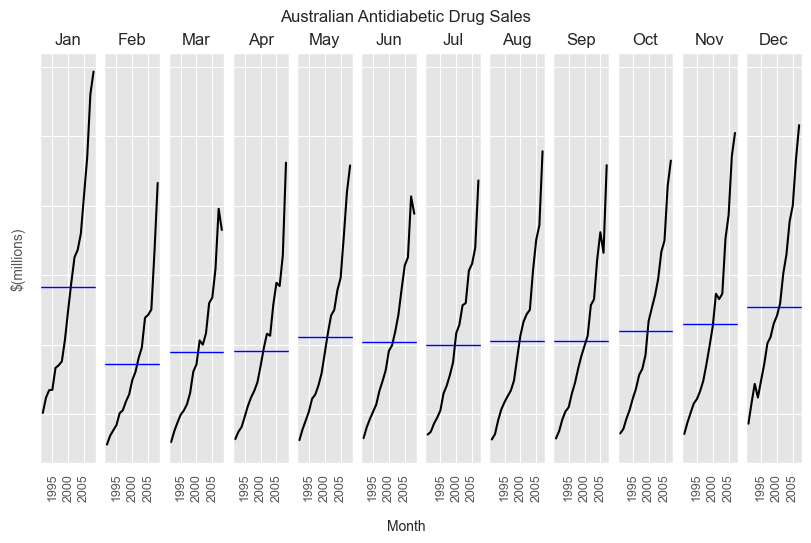

In [28]:
total_cost_df["Month"] = pd.to_datetime(total_cost_df["Month"])
total_cost_df["year"] = total_cost_df["Month"].dt.year
total_cost_df["month"] = total_cost_df["Month"].dt.strftime("%B")
total_cost_df["month"] = pd.Categorical(
  total_cost_df["month"],
  categories=[
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December",
  ],
  ordered=True,
)

fig, axes = plt.subplots(nrows=1, ncols=12, sharey=True)
for i, month in enumerate(total_cost_df["month"].cat.categories):
    month_data = total_cost_df.query("month == @month")
    mean_cost = month_data["Cost"].mean()
    axes[i].plot(month_data["year"], month_data["Cost"], color="black")
    axes[i].axhline(
        mean_cost, color="blue", linestyle="-", linewidth=1, label="Average"
    )
    axes[i].set_title(month[:3])
    axes[i].set_xlabel("")
    axes[i].tick_params(axis='x', rotation=90)
    if i == 0:
        axes[i].set_ylabel("$(millions)")
    else:
        axes[i].set_yticklabels([])

fig.suptitle("Australian Antidiabetic Drug Sales")
fig.text(0.5, -0.05, "Month", ha="center")
fig.subplots_adjust(wspace=0.2)
fig.show()

Blue lines indicate means for each month. This plot enables the underlying season pattern to be seen clearly, and shows changes in seasonality over time as well as changes within particular seasons. 

### Example: Australian holiday tourism

First, extract relevant data from the `tourism` dataframe by computing the total visitor nights spent on holiday for each quarter, grouped by state (and ignoring regions):

In [29]:
tourism = pd.read_csv("./data/tourism.csv")
tourism["ds"] = pd.to_datetime(tourism["ds"])
tourism["Quarter"] = tourism["ds"].dt.to_period("Q").astype(str)
tourism_sub = tourism.query('Purpose == "Holiday"')
trips = tourism_sub.groupby(["State", "ds"], as_index=False)["y"].sum()

In [30]:
trips.head()

,State,ds,y
0,ACT,1998-01-01,196.219
1,ACT,1998-04-01,126.771
2,ACT,1998-07-01,110.680
3,ACT,1998-10-01,170.472
4,ACT,1999-01-01,107.779


Now, plot each of these series to reveal strong seasonality for most states that does not coincide. For example, Queensland and New South Wales have peaks and troughs that occur opposite to each other.

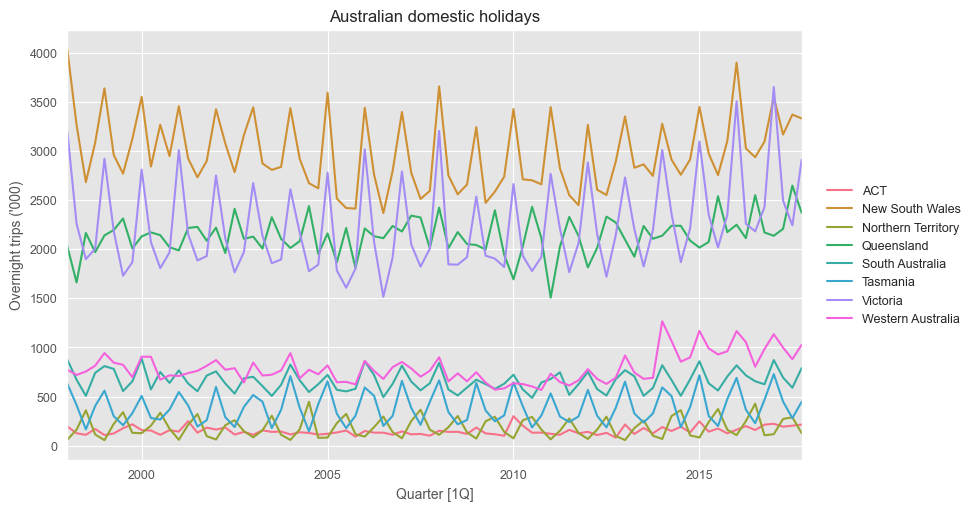

In [31]:
states = trips["State"].unique()
colors = sns.color_palette("husl", len(states))
fig, ax = plt.subplots()
for state, color in zip(states, colors):
    state_df = trips.query("State == @state")
    state_df.plot(y="y", x="ds", ax=ax, label=state, color=color)
ax.set_title("Australian domestic holidays")
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    borderaxespad=0,
)
ax.set_ylabel("Overnight trips ('000)")
ax.set_xlabel("Quarter [1Q]")
fig.show()

Let's look at yearly seasonal plots by state to investigate this further:

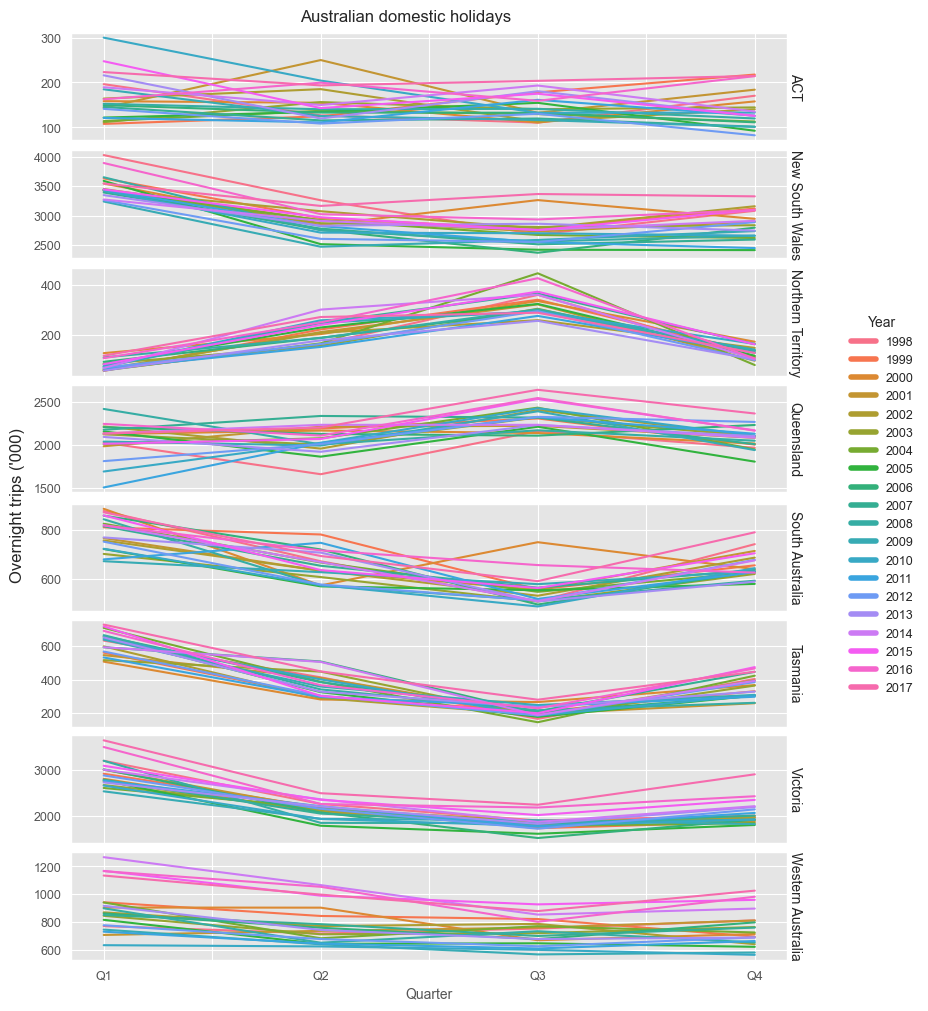

In [32]:
trips["Quarter"] = "Q" + trips["ds"].dt.quarter.astype(str)
trips["Year"] = trips["ds"].dt.year
years = sorted(trips["Year"].unique())
palette = sns.color_palette("husl", len(years))
year_to_color = dict(zip(years, palette))
n_states = trips["State"].nunique()
fig, axs = plt.subplots(n_states, 1, sharex=True, figsize=(8, 10))
for ax, (state, df_state) in zip(axs, trips.groupby("State")):
  pivot_data = df_state.pivot(index="Quarter", columns="Year", values="y")
  pivot_data.plot(ax=ax, 
    color=[year_to_color[year] for year in pivot_data.columns])
  ax.get_legend().remove()
  ax.text(1.02, 0.5, state, va="center", ha="right", rotation=270,
    fontsize=10, transform=ax.transAxes)
handles = [plt.Line2D([0], [0], 
  color=year_to_color[year], lw=4) for year in years]
labels = [str(year) for year in years]
fig.legend(handles, labels, title="Year", loc="center left", 
  bbox_to_anchor=(1.05, 0.5), frameon=False, borderaxespad=0)
fig.supylabel("Overnight trips ('000)")
fig.suptitle("Australian domestic holidays")
fig.show()

This makes it clear that Tasmania, Victoria, and South Australia (southern states) have their strongest tourism in Q1 (their summer), while Queensland and the Northern Territory have strongest tourism in Q3 (their dry season).

Now the subseries plots:

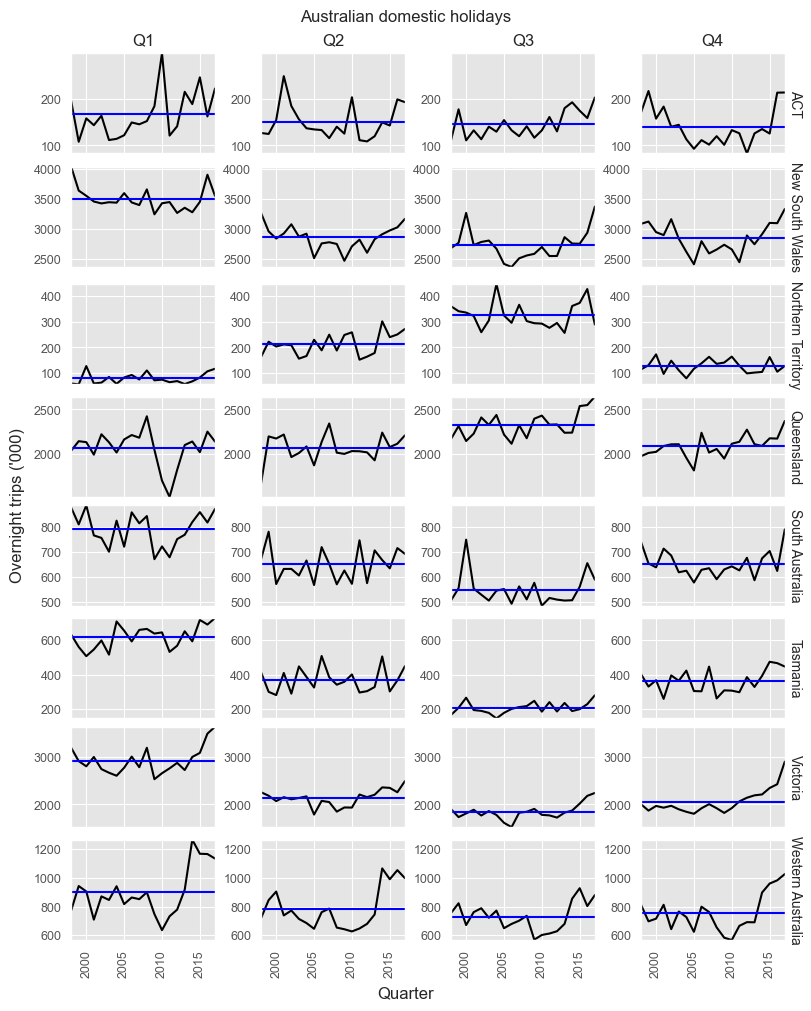

In [33]:
fig, axs = plt.subplots(n_states, 4, sharex=True, figsize=(8, 10))
axs = axs.flatten()
quarters = sorted(trips["Quarter"].unique())
states = sorted(trips["State"].unique())
for idx, (state_i, df_state) in enumerate(trips.groupby("State")):
    y_state_min, y_state_max = df_state["y"].min(), df_state["y"].max()
    for jdx, (quart_i, df_state_quart) in \
            enumerate(df_state.groupby("Quarter")):
        axi = axs[idx * 4 + jdx]
        df_state_quart.plot(y="y", x="ds", label=None, ax=axi,
            color="black")
        axi.axhline(df_state_quart["y"].mean(), color="blue")
        axi.set_ylim(y_state_min, y_state_max)
        axi.set_xlabel("")
        axi.tick_params(axis="x", rotation=90)
        axi.get_legend().remove()
for j, quarter in enumerate(quarters):
    axs[j].set_title(quarter)
for i, state in enumerate(states):
    axs[i * 4 + 3].text(
        1.02, 0.5, state, va="center", ha="left", rotation=270,
        transform=axs[i * 4 + 3].transAxes
    )
fig.supylabel("Overnight trips ('000)", va="center", rotation=90)
fig.supxlabel("Quarter", ha="center")
fig.suptitle("Australian domestic holidays")
fig.show()

This plot reveals, for example, that Western Australian tourism has increased noticeably across all quarters in recent years. Victorian tourism has increased in Q1 and Q4, but not so much for Q2 and Q3. 

## 2.6 Scatterplots

The plots so far have been useful for visualizing individual time series. Additionally, we can also explore the relationships *between* time series. For example, we can look at the relationship between half-hour electricity demand and temperature. Time plots of each of these series is shown below. 

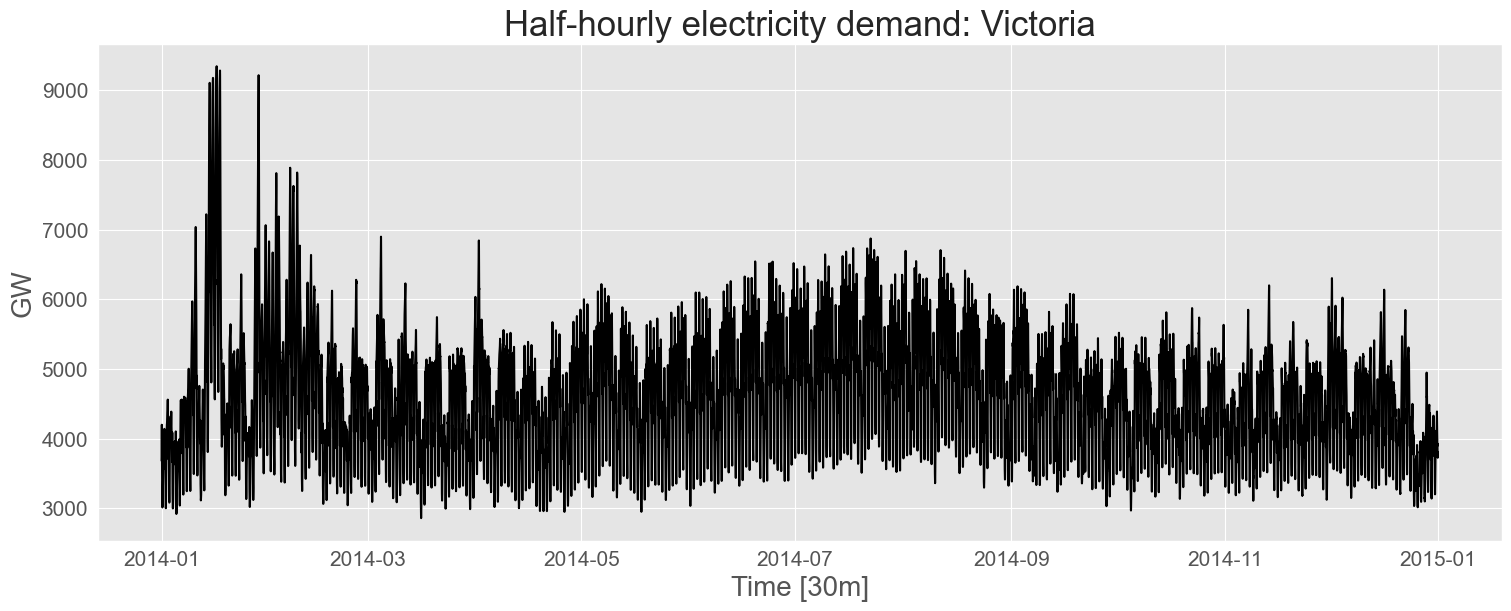

In [34]:
plot_series(vic_elec_df, ids=["Demand"],
            max_insample_length=2 * 24 * 365,
            xlabel="Time [30m]",
            ylabel="GW",
            title="Half-hourly electricity demand: Victoria")

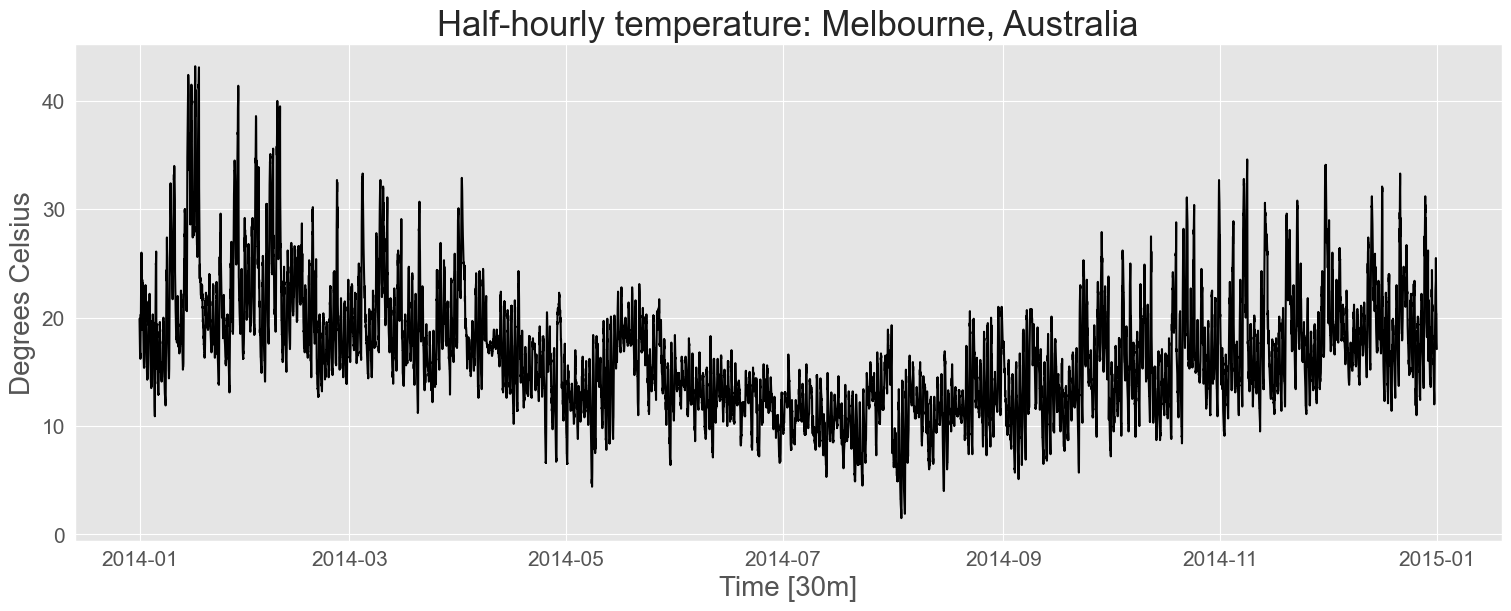

In [35]:
plot_series(vic_elec_df, ids=["Temperature"],
            max_insample_length=2 * 24 * 365,
            xlabel="Time [30m]",
            ylabel="Degrees Celsius",
            title="Half-hourly temperature: Melbourne, Australia")

Start by plotting one series against the other. 

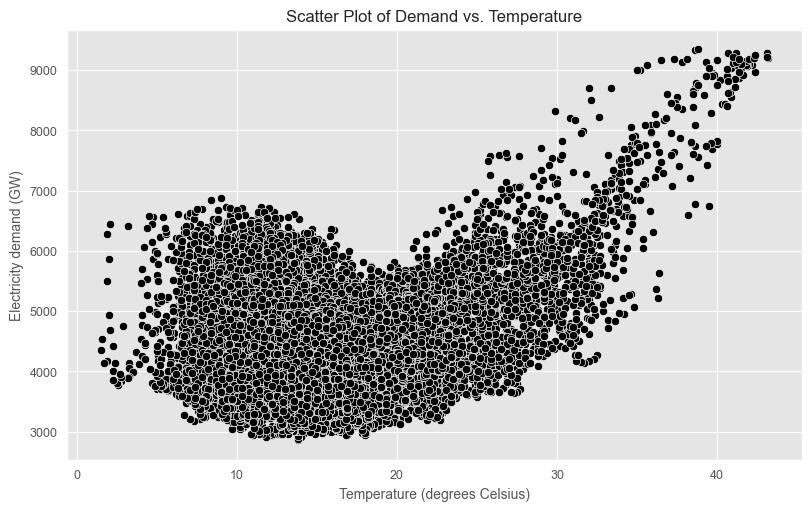

In [36]:
elec_2014 = vic_elec_df.query('ds >= "2014"')
elec_2014_pivot = elec_2014.pivot(
    index=["ds", "Holiday"], columns="unique_id", values="y"
).reset_index()
fig, ax = plt.subplots()
sns.scatterplot(data=elec_2014_pivot, x="Temperature", y="Demand", ax=ax)
ax.set_title("Scatter Plot of Demand vs. Temperature")
ax.set_xlabel("Temperature (degrees Celsius)")
ax.set_ylabel("Electricity demand (GW)")
fig.show()

From this it's clear that electricity demand increases with both low temperatures and high temperatures, but decreases for more temperate weather.

### Correlation

The *correlation coefficient* $r$ measures the strength of the **linear** relationship between two variables and always lies between -1 and 1. It is given by $$r = \frac{ \sum (x_t - \overline{x})(y_t - \overline{y})}{\sqrt{\sum (x_t -\overline{x})^2}\sqrt{\sum (y_t -\overline{y})^2}}.$$

### Scatterplot matrices

With multiple different predictor variables, it's helpful to plot each variable against each other variable. Below are eight time plots showing quarterly visitor numbers across states/territories of Australia:

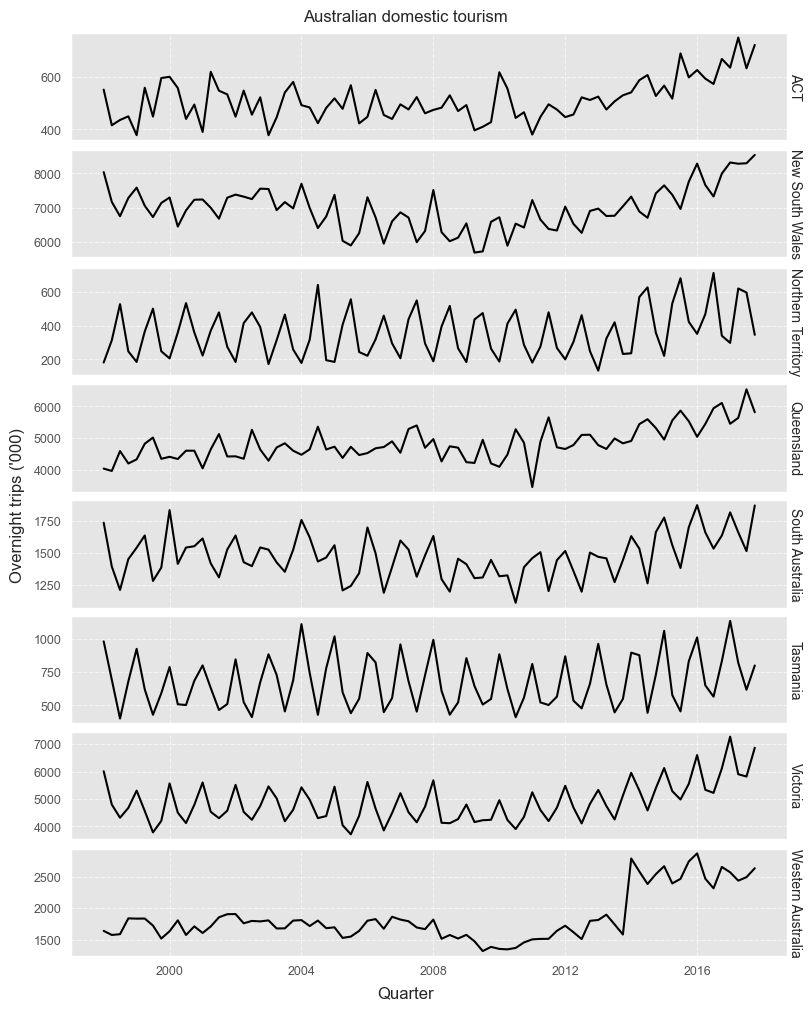

In [37]:
visitors = tourism.groupby(["State", "ds"], as_index=False)["y"].sum()
n_states = visitors["State"].nunique()
fig, axs = plt.subplots(n_states, 1, sharex=True, figsize=(8, 10))
for ax, (state, df_state) in zip(axs, visitors.groupby("State")):
    ax.plot(df_state["ds"], df_state["y"])
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.text(1.02, 0.5, state, va="center", ha="right",
        rotation=270, transform=ax.transAxes)
fig.suptitle("Australian domestic tourism")
fig.supylabel("Overnight trips ('000)", va="center", rotation=90)
fig.supxlabel("Quarter", ha="center")
fig.show()

To see the relationships between them, we can plot each series against the others and arrange them in a scatterplot matrix. 

/Users/david/dev/fpp/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


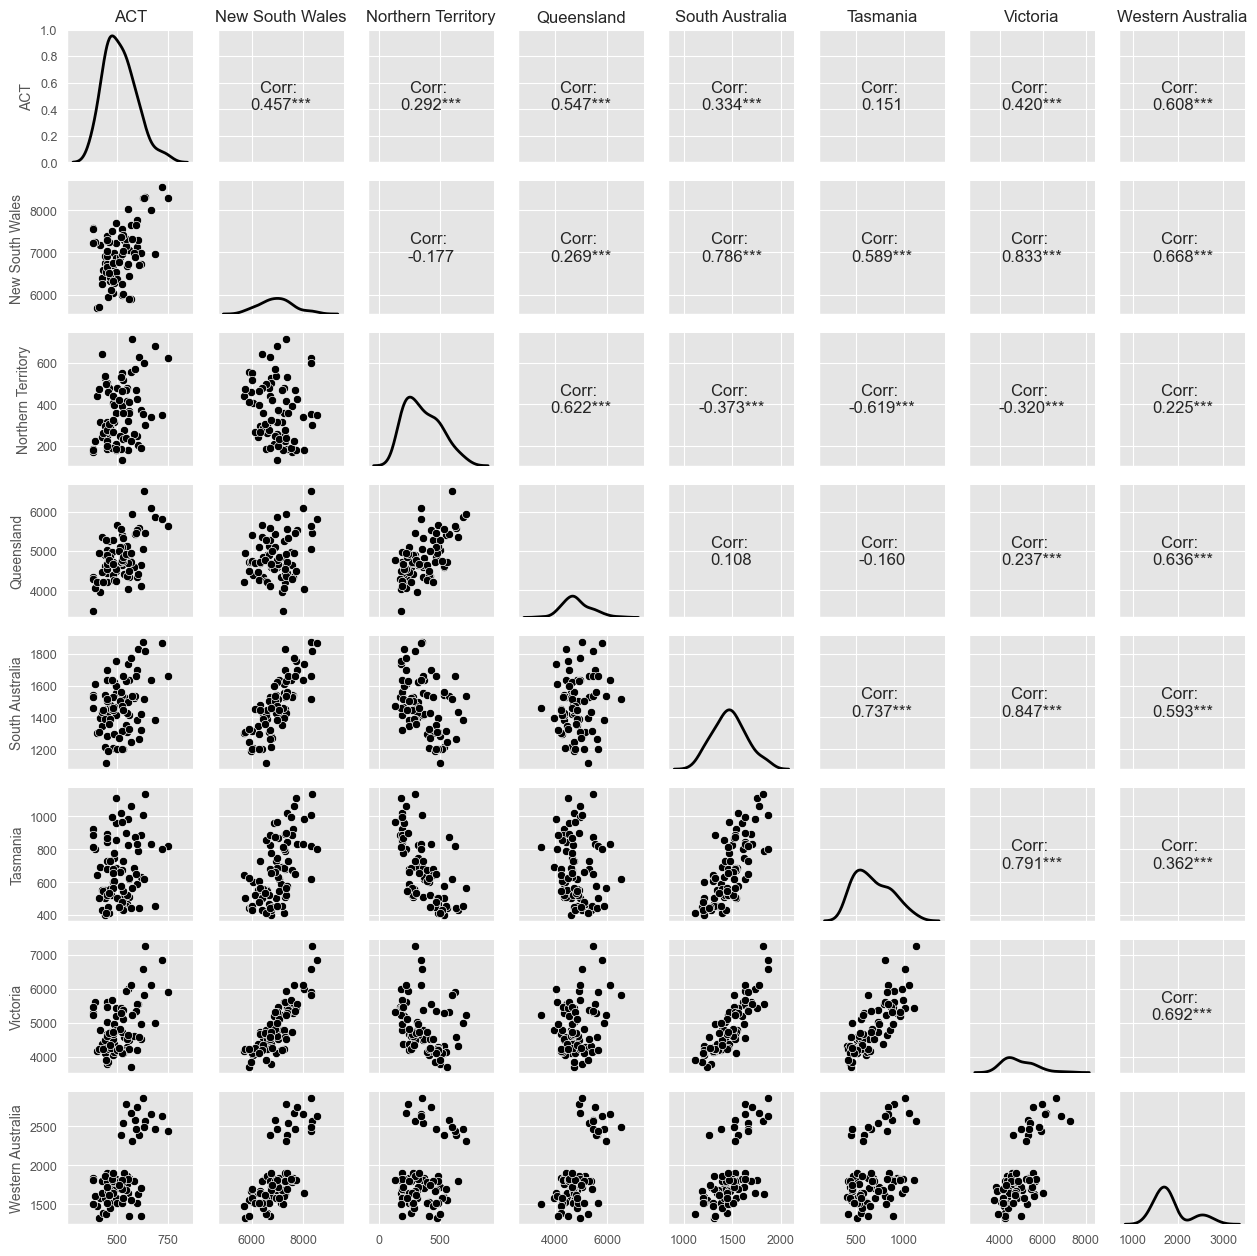

In [38]:
visitors_pivot = \
    visitors.pivot(index="ds", columns="State", values="y").reset_index()
df_for_plot = visitors_pivot.drop(columns=["ds"])
def corrfunc(x, y, **kws):
    r, pvalue = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        f"Corr: \n{r:.3f}{'***' if pvalue < 0.05 else ''}",
        xy=(0.5, 0.5), xycoords="axes fraction",
        ha="center", va="center", fontsize=12,
    )
g = sns.PairGrid(df_for_plot, height=1.6)
g.map_lower(sns.scatterplot)
g.map_upper(corrfunc)
g.map_diag(sns.kdeplot, lw=2)
g.set(xlabel="")
for i, col in enumerate(df_for_plot.columns):
    g.axes[0, i].set_title(col, fontsize=12)
fig.show()

This particular scatter matrix shows the scatterplots below the diagonal, correlation coefficients above the diagonal, and density plots on the diagonal. 

## 2.7 Lag plots

Another plot we can make is a lag plot, which plots a time series $y_t$ against lagged values of itself $y_{t-k}$ for different lags $k$. 

In [39]:
aus_production = pd.read_csv("./data/aus_production.csv")
aus_production["ds"] = pd.to_datetime(aus_production["ds"])

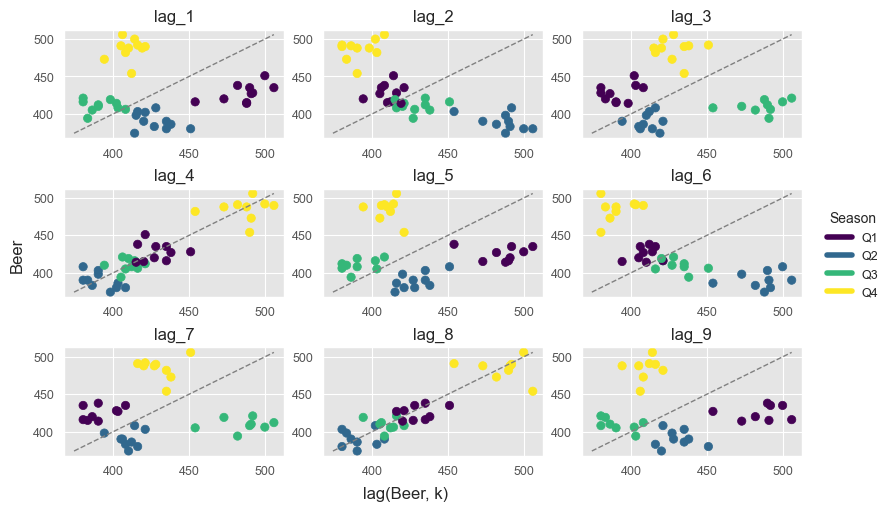

In [40]:
recent_production = aus_production[["ds", "Beer"]].query("ds >= 2000")
recent_production.rename(columns={"Beer": "y"}, inplace=True)
recent_production["ds"] = pd.to_datetime(recent_production["ds"])
recent_production["Quarter"] = recent_production["ds"].dt.quarter

for lag in range(1, 10):
    recent_production[f"lag_{lag}"] = recent_production["y"].shift(lag)
lags = [f"lag_{i}" for i in range(1, 10)]
lims = [
    np.min([recent_production[lag].min() for lag in lags] +
        [recent_production["y"].min()]),
    np.max([recent_production[lag].max() for lag in lags] +
        [recent_production["y"].max()]),
]
fig, axes = plt.subplots(3, 3)
for ax, lag in zip(axes.flatten(), lags):
    ax.scatter(
        recent_production[lag],
        recent_production["y"],
        c=recent_production["Quarter"],
        cmap="viridis"
    )
    ax.plot(lims, lims, "grey", linestyle="--", linewidth=1)
    ax.set_title(lag)
unique_quarters = sorted(recent_production["Quarter"].unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_quarters)))
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
labels = [f"Q{q}" for q in unique_quarters]
fig.legend(handles, labels, title="Season", loc="center left", 
    bbox_to_anchor=(1.02, .5),
    frameon=False, borderaxespad=0,)
fig.supxlabel("lag(Beer, k)")
fig.supylabel("Beer")
fig.show()

Note the strong positive correlation at lags 4 and 8, reflecting the strong yearly seasonality in the data. Also, we can see a strong negative correlation at lags 2 and 6, showing that peaks (in Q4) get plotted against troughs (in Q2).

## 2.8 Autocorrelation

Autocorrelation measures the strength of the linear relationship between a time series and *lagged* values of itself. 

There are several autocorrelation coefficients depending on the lag value $k$ being considered: $r_1$ measures the relationship between $y_t$ and $y_{t-1}$, $r_2$ measures the relationship between $y_t$ and $y_{t-2}$, etc. 

The $k$-th autocorrelation coefficient $r_k$ is computed as $$r_k = \frac{ \sum_{t=k+1}^T (y_t - \overline{y})(y_{t-k} - \overline{y})}{\sum_{t=1}^T (y_t -\overline{y})^2},$$

where $T$ is the length of the time series. The autocorrelation coefficients make up the *autocorrelation function*. 

Below we compute some autocorrelation coefficients for the beer production data using `acf()`. 

In [41]:
acf_df = pd.DataFrame(
    {"Lag": range(10), "ACF": sm.tsa.acf(recent_production["y"], nlags=9,
        fft=False, bartlett_confint=False)}
).set_index("Lag")
acf_df[1:]

,ACF
Lag,
1,-0.053
2,-0.758
3,-0.026
4,0.802
5,-0.077
6,-0.657
7,0.001
8,0.707
9,-0.089


Additionally, we can plot the ACF to see how correlations change with the lag $k$. This plot is sometimes known as a correlogram. 

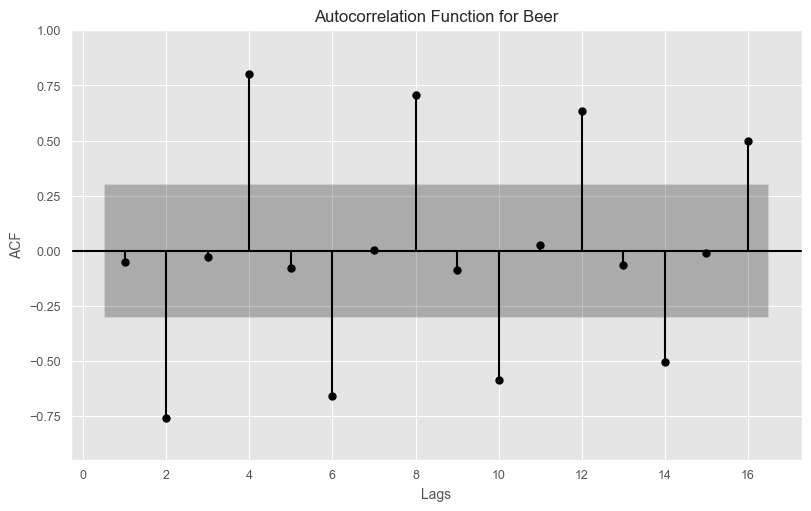

In [42]:
recent_production["ds"] = pd.to_datetime(recent_production["ds"])
fig, ax = plt.subplots()
plot_acf(recent_production["y"], lags=16,
         ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True)

ax.set_title("Autocorrelation Function for Beer")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")

fig.show()

The shaded dark grey region indicates whether the correlations are significantly different from zero (see Section 2.9).

### Trend and seasonality in ACF plots 

When data has a trend, small-lag autocorrelations tend to be large and positive because observations nearby in time are also nearby in value. So the ACF of a trended time series tends to have positive values that slowly decrease as the lags increase. 

When data are seasonal, the autocorrelations will be larger for the seasonal lags at multiples of the seasonal period than they will for other lags. 

When data are both trended and seasonal, you see both of these effects. Consider the `total_cost_df` which shows both trend and seasonality, and the ACF which is plotted below. The slow decrease in the ACF as the lags increase is due to the trend, while the "scalloped" shape is due to the seasonality. 

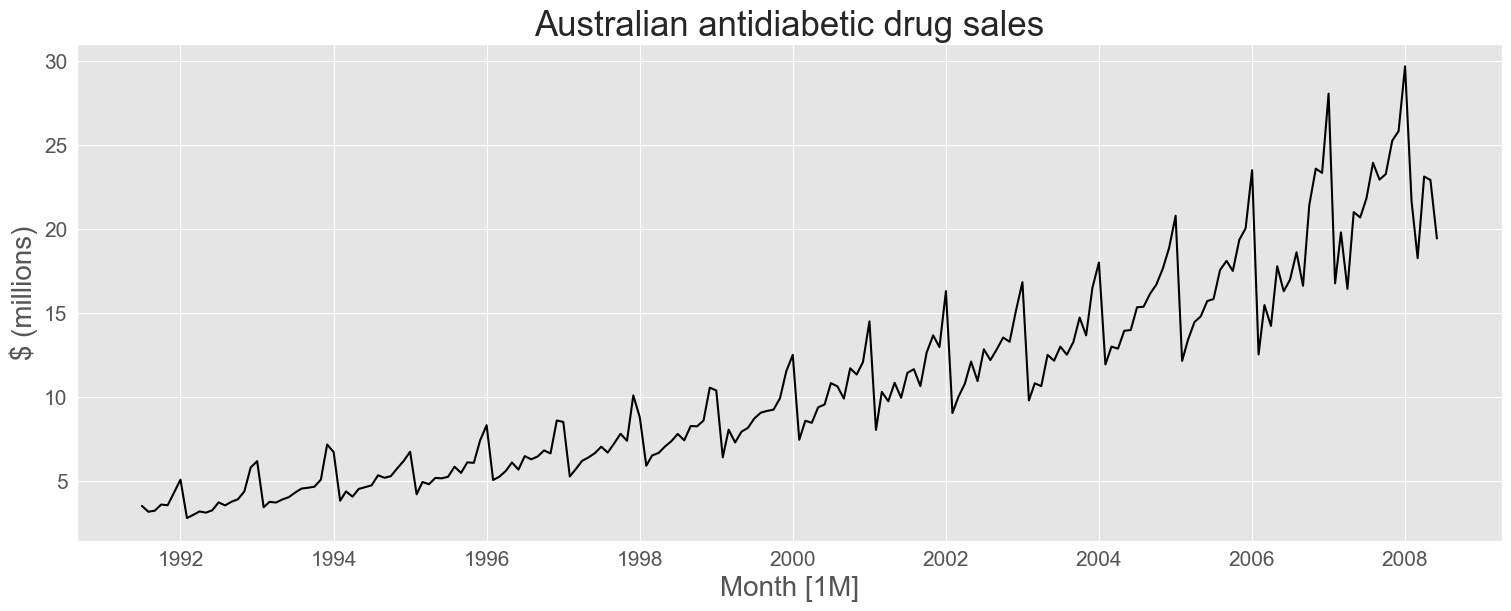

In [43]:
total_cost_df["unique_id"] = "total_cost" # Create a unique id column
plot_series(
  total_cost_df,
  id_col="unique_id", time_col="Month", target_col="Cost",
  xlabel="Month [1M]", ylabel="$ (millions)",
  title="Australian antidiabetic drug sales"
)

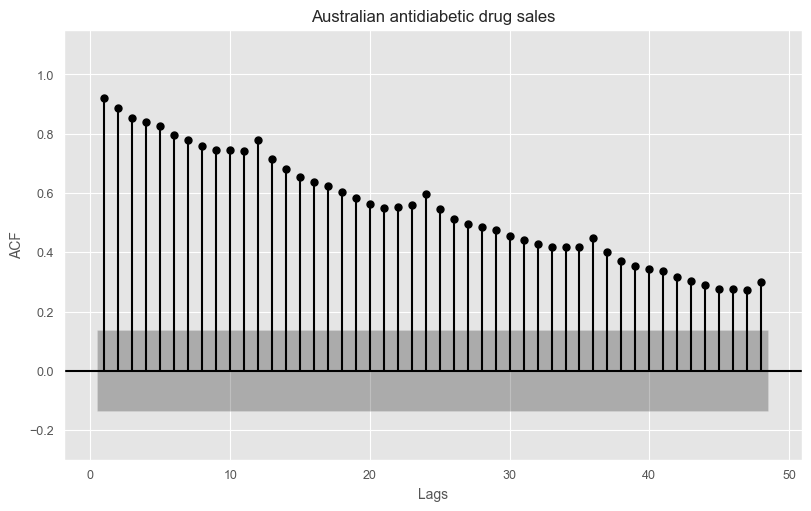

In [44]:
total_cost_df["Month"] = pd.to_datetime(total_cost_df["Month"])
fig, ax = plt.subplots()
plot_acf(
  total_cost_df["Cost"], lags=48, ax=ax,
  zero=False, bartlett_confint=False, auto_ylims=True
)
ax.set_title("Australian antidiabetic drug sales")
ax.set_xlabel("Lags")
ax.set_ylabel("ACF")
ax.set_ylim(bottom=-0.3)
fig.show()

## 2.9 White noise 

Time series with no autocorrelation are called **white noise**. See an example below.

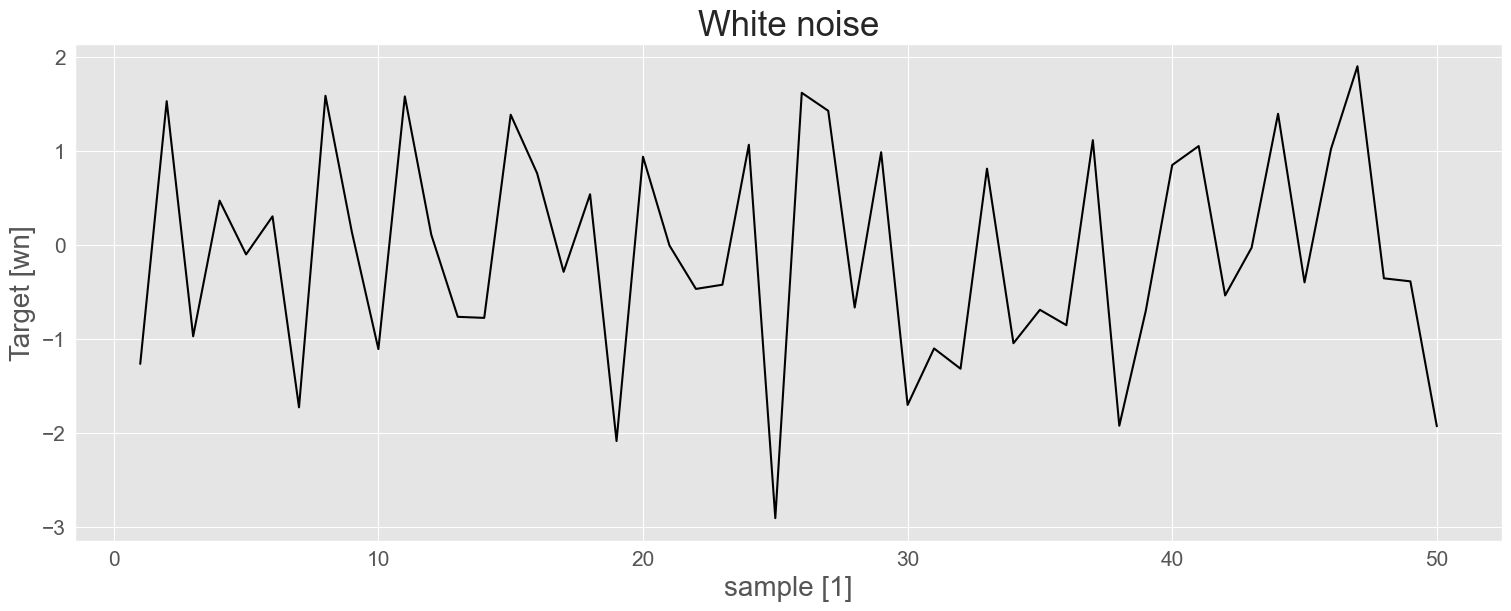

In [45]:
np.random.seed(30)
y = pd.DataFrame(
  {"wn": np.random.normal(0, 1, 50), "ds": np.arange(1, 51),
   "unique_id": "wn"}
)
plot_series(y, 
  target_col="wn", xlabel="sample [1]", title = "White noise"
)

The ACF of this series is as follows.

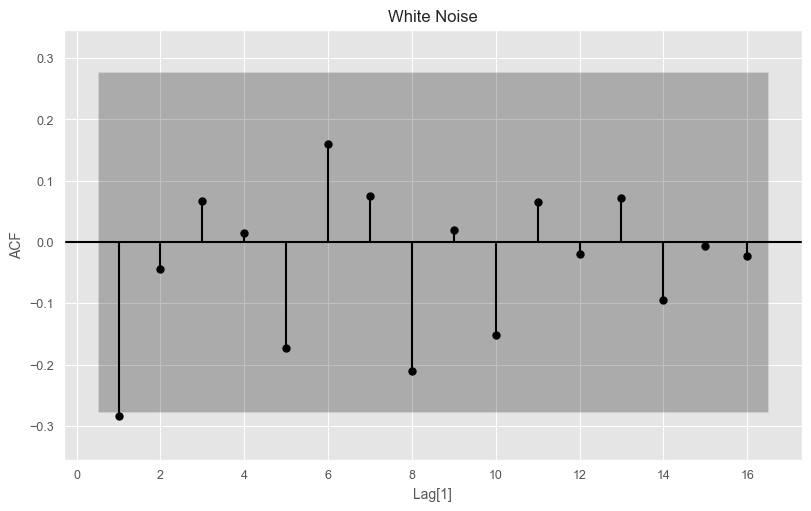

In [46]:
fig, ax = plt.subplots()
plot_acf(y["wn"], 
  lags=16, ax=ax, zero=False, bartlett_confint=False,
  auto_ylims=True
)
ax.set_title("White Noise")
ax.set_xlabel("Lag[1]")
ax.set_ylabel("ACF")
#ax.set_ylim(bottom=-0.3)
fig.show()

For white noise, we expect each autocorrelation coefficient to be close to zero; more specifically, we expect 95% of the spikes in the ACF to lie within $\pm 1.96/\sqrt{T} $ where $T$ is the length of the time series. These bounds are displayed as the grey region in the plot above. If any of these spikes (or substantially more than 5% of them) are outside these bounds then the series is probably not white noise. 

Here, $T=50$ so the bounds are at $\pm 0.28$. All but the first coefficient are inside these bounds, and the first is only just outside, confirming the fact that the data are white noise. 

## 2.10 Exercises

### 7

Monthly Australian retail data is provided in aus_retail. Select one of the time series as follows (but choose your own seed value):
```python
np.random.seed(12345678)
random_series_id = \
    np.random.choice(aus_retail['Series ID'].unique(), 1)[0]
myseries = aus_retail.query('`Series ID` == @random_series_id')
```
Explore your chosen retail time series using the following functions:

`plot_series()`, `seasonal_decompose()`, `lag_plot()`, `plot_acf()`

Can you spot any seasonality, cyclicity and trend? What do you learn about the series?

### 7 Solution

In [47]:
aus_retail = pd.read_csv("./data/aus_retail.csv", parse_dates=["Month"])

np.random.seed(123)
random_series_id = np.random.choice(aus_retail['Series ID'].unique(), 1)[0]
myseries = aus_retail.query('`Series ID` == @random_series_id')
myseries.head()

,State,Industry,Series ID,Month,Turnover
45569,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-04-01,4.0
45570,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-05-01,4.0
45571,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-06-01,3.9
45572,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-07-01,4.4
45573,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,1982-08-01,4.2


In [48]:
myseries.shape

(441, 5)

In [49]:
myseries.set_index("Month", inplace=True)
myseries.head()

,State,Industry,Series ID,Turnover
Month,,,,
1982-04-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.0
1982-05-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.0
1982-06-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,3.9
1982-07-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.4
1982-08-01,Tasmania,"Pharmaceutical, cosmetic and toiletry goods retailing",A3349671C,4.2


In [51]:
state = myseries['State'].unique()[0]
state

'Tasmania'

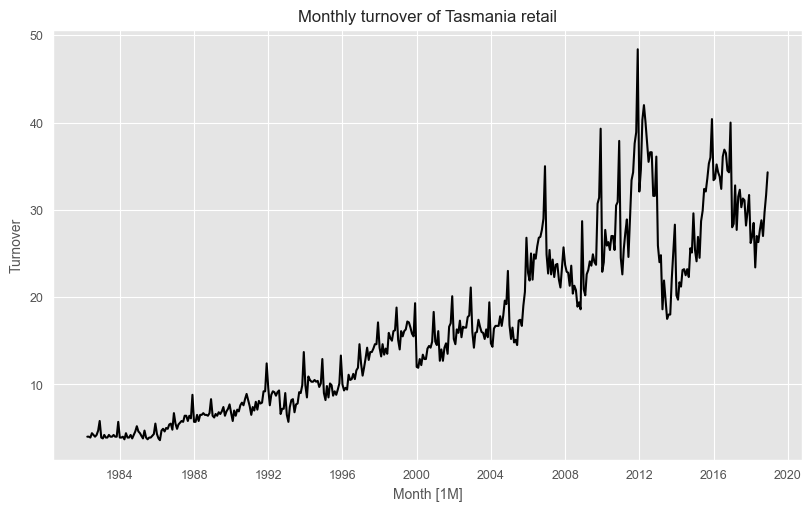

In [53]:
plt.plot(myseries.index, myseries["Turnover"])
plt.xlabel("Month [1M]")
plt.ylabel("Turnover")
plt.title(f"Monthly turnover of {state} retail")
plt.show()

/Users/david/dev/fpp/.venv/lib/python3.12/site-packages/statsmodels/tsa/seasonal.py:360: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


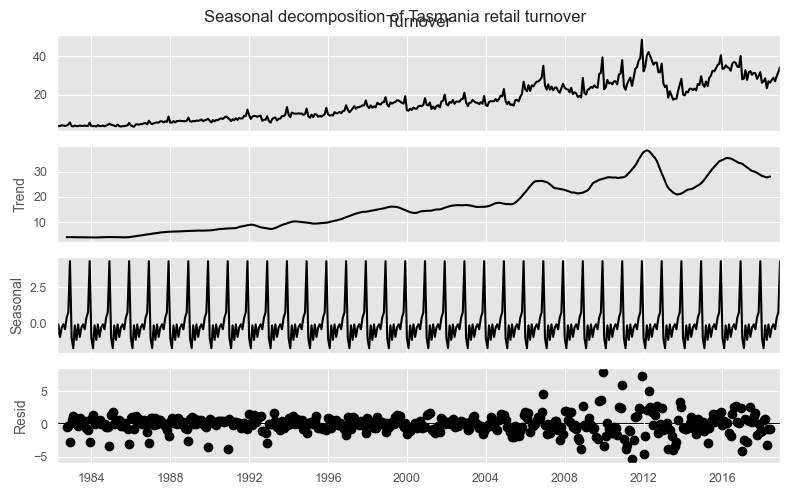

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(myseries["Turnover"], model="additive", period=12).plot()
plt.suptitle(f"Seasonal decomposition of {state} retail turnover")
plt.show()

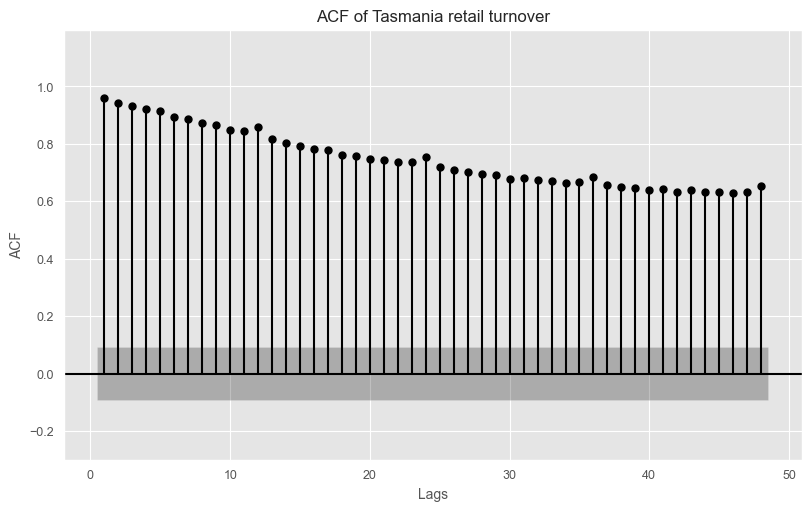

In [59]:
plot_acf(myseries["Turnover"], lags=48, zero=False, bartlett_confint=False, auto_ylims=True)
plt.title(f"ACF of {state} retail turnover")
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.ylim(bottom=-0.3)
plt.show()

Based on these plots, we notice several things. For one, the slow decrease in the ACF as the lags increase is due to the trend. We see evidence of the trend in both the time plot and in the trend-cycle component of the decomposition.

Furthermore there is clear yearly seasonality, evident both in the seasonal component of the decomposition as well as in the "scalloping" behavior in the ACF. Thus the seasonal period is $m=12$ months. 

There does appear to be some cyclic behavior starting about 2004 onward, with a period of roughly 4 years. 